# Part 3: Data Analysis (40%)

#### Import Libaries

In [455]:
# General Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# API Packages
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

## Step 1: Crawl a real-world dataset

We will be looking at the 100 most recently released albums using the Spotify API and exploring the dataset on a track level in the following notebook. We shall be requesting a combination of identification features such as song name and album name etc. alongside audio features such as popularity and loudness ratings. These numeric values will be the playground in which a lot of our analysis will be taking place and the interaction between these features and our object variables. 

In [445]:
# Authenticate spotify id and secret
sp = spotipy.Spotify(
    auth_manager = SpotifyClientCredentials(
        client_id = '262f1d55233c40938cb157f5f2a45beb',
        client_secret = '5ec6a7c82c1e402294f64217d662f58f'
    )
)

Since the maximum number of albums can be requested is 50, we shall be sending two requests one with an offset of 50. So the first request will call albums 1-50 and the second request albums 51-100.

In [446]:
# Request 50 most recent releases to start our dataset
new_releases = sp.new_releases(
    country = 'GB',
    limit = 50
)

# Request albums 51-100 to add to our dataset
new_releases_next_50 = sp.new_releases(
    country= 'GB',
    limit = 50,
    offset = 50
)

# Combine the requests into new_releases
new_releases['albums']['items'].extend(new_releases_next_50['albums']['items'])

In [447]:
def get_album_uri_and_names(nr_data):
    ''' This function gets all the uris and ablum names from a new release requests and outputs it out as a tuple of two lists.
    
        ---Parameters---
        nr_data: dict
        dictionary of call requests from new_release spotipy method.
        
        ---Returns---
        (album_names, album_uri): tuple
        tuple of two lists. first list contains the album names of the request and the second contains the uris of the request.
    '''
    
    album_names = [i['name'] for i in nr_data['albums']['items']]
    album_uri = [i['uri'] for i in nr_data['albums']['items']]

    return (album_names, album_uri)

In [439]:
# Get album names and album uris from new_releases request
nr_album_names, nr_album_uri = get_album_uri_and_names(new_releases)

In [440]:
# Define features that we want for our analysis
audio_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
track_info_features = ['artist', 'name', 'duration_ms', 'explicit', 'track_number']
additional_features = ['album', 'popularity']

In [453]:
def get_song_uris_from_album(album_uri):
    '''Function to create list of the album song uris from the album's uri.

    ---Parameters---
    album: str
    string of the album uri

    ---Returns---
    song_uris: list
    list of song uris    
    '''

    song_uris = [song['uri'] for song in sp.album_tracks(album_uri)['items']]

    return song_uris


def get_track_features(input_dict, song_uri):
    '''Function that takes a song uri and adds the song information to an input dictionary.

    ---Paramters---
    input_dict: dict
    dictionary of the form {'feature1' : [...], 'feature2' : [...], ...}
    song_uri: str
    string of song uri

    ---Returns---
    input_dict: dict
    dictionary containing the song information of the album uri
    '''

    sp_track = sp.track(song_uri)

    for k in additional_features + track_info_features:
        if k == 'album':
            input_dict[k].append(sp_track['album']['name'])
        elif k == 'popularity':
            input_dict[k].append(sp_track['popularity'])
        elif k == 'artist':
            input_dict[k].append(sp_track['album']['artists'][0]['name'])
        else:
            input_dict[k].append(sp_track[k])
            
    return input_dict

    
def get_audio_features(input_dict, song_uri):
    '''Function that adds audio feature information to an input dictionary from a specified song uri
    
    ---Paramters---
    input_dict: dict
    dictionary of the form {'feature1' : [...], 'feature2' : [...], ...}
    song_uri: str
    strinf of the song uri

    ---Returns---
    input_dict: dict
    dictionary containing the song information of the album uri
    '''

    audio = sp.audio_features(song_uri)[0]

    for k in audio_features:
        if audio is None:
            input_dict[k].append(None)
        else:
            input_dict[k].append(audio[k])

    return input_dict


def get_album_info(album_uri):
    '''Function that gets all the song information features from a specified album uri.
    
    ---Parameters---
    album_uri: str
    string of an album uri
    album_names: str
    strong of the album name

    ---Returns---
    track_info: dict
    dictionary of the form {'feature1' : [...], 'feature2' : [...], ...}
    '''

    track_info = {k : [] for k in additional_features + track_info_features + audio_features}

    nr_song_uris = get_song_uris_from_album(album_uri)

    for song_uri in nr_song_uris:

        track_info = get_track_features(track_info, song_uri)

        track_info = get_audio_features(track_info, song_uri)

    return track_info

In [454]:
nr_songs = {k : [] for k in additional_features + track_info_features + audio_features}

for album_uri in nr_album_uri:

    album_info = get_album_info(album_uri)

    for k, v in album_info.items():
        nr_songs[k] += v

print(f'--- Done! {len(nr_album_names)} Albums added ---')

--- Done! 100 Albums added ---


In [381]:
# Convert dictionary of results into dataframe
data = pd.DataFrame.from_dict(nr_songs)

## Step 2: Perform data preparation & cleaning

In [351]:
# Display data shape
data.shape

(1296, 18)

In [352]:
# Display data columns
data.columns

Index(['album', 'popularity', 'artist', 'name', 'id', 'uri', 'duration_ms',
       'explicit', 'track_number', 'danceability', 'energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo'],
      dtype='object')

In [353]:
# Rename album and name columns to make them more explainable
data.rename(
    columns={'album': 'album_name', 'name' : 'song_name'},
    inplace=True
)

In [354]:
# Display Null value counts
data.isnull().sum(axis=0)

album_name          0
popularity          0
artist              0
song_name           0
id                  0
uri                 0
duration_ms         0
explicit            0
track_number        0
danceability        3
energy              3
loudness            3
speechiness         3
acousticness        3
instrumentalness    3
liveness            3
valence             3
tempo               3
dtype: int64

No major missing values. Some of the audio features have 3 missing, but we expect that to just be two erroneous songs.

Would either look to imputing with album mean or excluding. Both appropriate due to few cases.

In [355]:
# Drop un-needed columns
data.drop(
    columns = ['id', 'uri'],
    axis=1,
    inplace=True
)

In [356]:
# Get rid of rows that contain missing values
data.dropna(
    axis=0,
    inplace=True
)

In [357]:
# Get album length from value_counts
data['album_length'] = data.album_name.map(data.album_name.value_counts().to_dict())

In [358]:
# Display data column types
data.dtypes

album_name           object
popularity            int64
artist               object
song_name            object
duration_ms           int64
explicit               bool
track_number          int64
danceability        float64
energy              float64
loudness            float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
album_length          int64
dtype: object

In [359]:
# Drop columns that are not needed
data_out = data.drop(
    columns=['track_number'],
    axis=1
)

data_out.head()

,album_name,popularity,artist,song_name,duration_ms,explicit,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,album_length
0,i wonder if you wonder,45,Grace Davies,somebody,225920,False,0.401,0.432,-8.144,0.0343,0.611,0.000000,0.101,0.3690,86.242,6
1,i wonder if you wonder,33,Grace Davies,i met a boy online,194603,False,0.386,0.353,-8.947,0.0375,0.715,0.000015,0.108,0.2970,120.982,6
2,i wonder if you wonder,33,Grace Davies,roots,214277,False,0.402,0.357,-11.505,0.0356,0.765,0.000000,0.132,0.0591,94.428,6
3,i wonder if you wonder,32,Grace Davies,testosterone,190078,False,0.435,0.353,-9.276,0.0469,0.841,0.000001,0.109,0.3380,109.132,6
4,i wonder if you wonder,32,Grace Davies,used to you,208213,False,0.387,0.487,-7.944,0.0483,0.228,0.000033,0.247,0.4020,154.093,6


## Step 3: Perform exploratory analysis and ask questions

In [360]:
# Define plot colours
colours = 'bgrcyk' * 3

In [361]:
# Define lists of feature types
object_features = ['song_name', 'album_name', 'artist']

numerical_features = ['popularity', 'danceability', 'energy', 'loudness', 'speechiness',
'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'album_length']

bool_features = ['explicit']

ignore_features = []

In [362]:
all_features = object_features + numerical_features + bool_features + ignore_features

print('All vars:', len(all_features))
print('data vars:', len(data_out.columns))

All vars: 16
data vars: 16


#### Numerical Vars

In [380]:
numeric_df = data_out[numerical_features]

numeric_summary = pd.concat(
    [
        numeric_df.count().rename('Count'),
        numeric_df.isnull().sum().rename('Null'),
        numeric_df.nunique().rename('Unique'),
        numeric_df.mean().round(3).rename('Mean'),
        numeric_df.median().round(3).rename('Median'),
        numeric_df.min().round(3).rename('Min'),
        numeric_df.max().round(3).rename('Max'),
        (numeric_df.max() - numeric_df.min()).round(3).rename('Range'),
        numeric_df.std().round(3).rename('Std Dev')
    ],
    axis=1
)

numeric_summary

,Count,Null,Unique,Mean,Median,Min,Max,Range,Std Dev
popularity,1293,0,83,49.211,48.000,0.000,100.000,100.000,15.030
danceability,1293,0,576,0.593,0.605,0.072,0.981,0.909,0.166
energy,1293,0,637,0.617,0.637,0.033,0.989,0.956,0.208
loudness,1293,0,1211,-7.624,-6.966,-33.809,-1.260,32.549,3.343
speechiness,1293,0,707,0.114,0.058,0.023,0.929,0.906,0.123
acousticness,1293,0,969,0.301,0.181,0.000,0.995,0.995,0.310
instrumentalness,1293,0,791,0.084,0.000,0.000,0.990,0.990,0.220
liveness,1293,0,569,0.193,0.125,0.023,0.985,0.962,0.171
valence,1293,0,687,0.454,0.444,0.018,0.967,0.948,0.228
tempo,1293,0,1262,119.973,120.047,45.481,206.014,160.533,28.725


#### Distributions

In this next section we will be looking at the distributions of the numeric variables in our dataset and try to answer the following questions:
- Do any variables look to be normally distributed?
- Are there any notable levels of kurtosis and skewness?

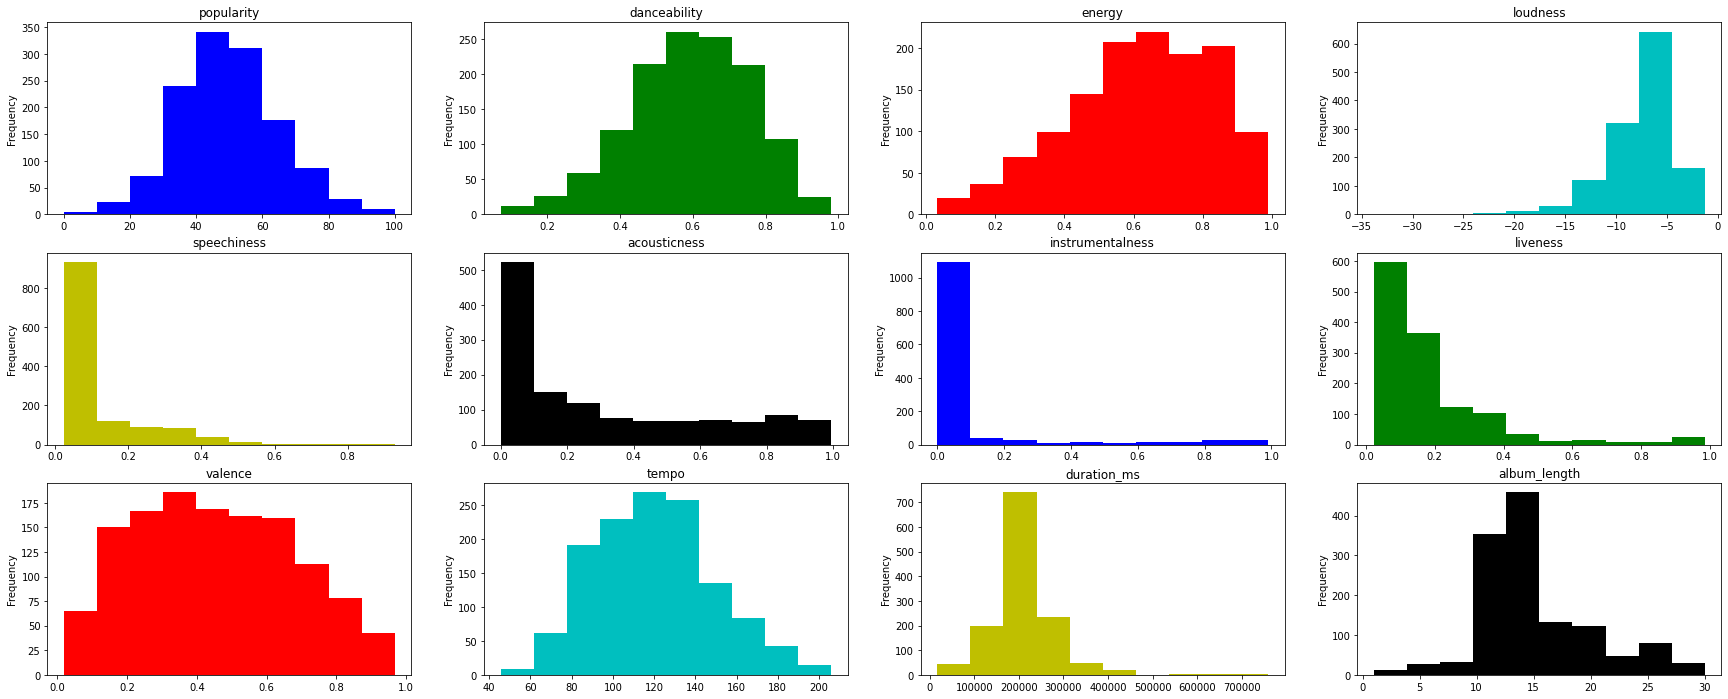

In [364]:
fig, ax = plt.subplots(
    nrows = (numeric_df.shape[1] // 4),
    ncols = 4,
    figsize = (30, numeric_df.shape[1])
)

for idx, col in enumerate(numeric_df.columns):
    x, y = idx // 4, idx % 4
    numeric_df[col].plot(
        ax = ax[x,y],
        kind = 'hist',
        color = colours[idx],
        legend = False,
        title = col
    )

plt.show()

#### Do any variables look to be normally distributed?

As we can see from the histograms, `popularity` and `duration_ms` are the only one that looks to have a histogram that resembles a normal distribution. Since these are arguably the most 'human' features, this would make sense. However, even between these two features, the kurtosis varies: `popularity` has a medium-leveled peak and `duration_ms` had a sharp peak suggesting it has more of a leptokurtic distribution.

Other variables are all skewed and has a different kurtosis. 


#### Are there any notable levels of kurtosis and skewness?

The variables that stand out from these histograms in terms of skew and kurtosis are `Valence`, `Instrumentalness`/`Acousticness`/`Speechiness` and `Energy`.

`Valence` (musical positivity conveyed by track) stands out due to is lack of major skew, and low levels of kurtosis. This tells us that, although the mean is `0.454` and it does peak at this point, there is less of a difference in frequency between the extremeties and the mean suggesting this variable is the most evenly spread.

`Instrumentalness`/`Acousticness`/`Speechiness` are all grouped together because they all show a similar distribution: a highly positive skew with an incredibly high kurtosis. This makes sense as these features tend to be more binary where a track has an emphasis on the the music and the instruments or it otherwise focusses on the lyrics. Something to potentially consider for these factors in future analysis is either to create a binary factor from them or disregard them in modelling if values greater than one are considered too rare.

`Energy` is also something that draws my eye because it has quite a large negative skew with low kurtosis. This suggests that songs with higher `energy` are currently being released - perhaps in preparation for christmas positivity. The low kutosis, in a similar way to `valence`, suggests that this variable is also more evenly spread than other variables.

#### Correlations

In this next section we will be looking at the correlations between numeric variables so that we can answer the following questions:

- Which features are strongly correlated?
- Is this expected?

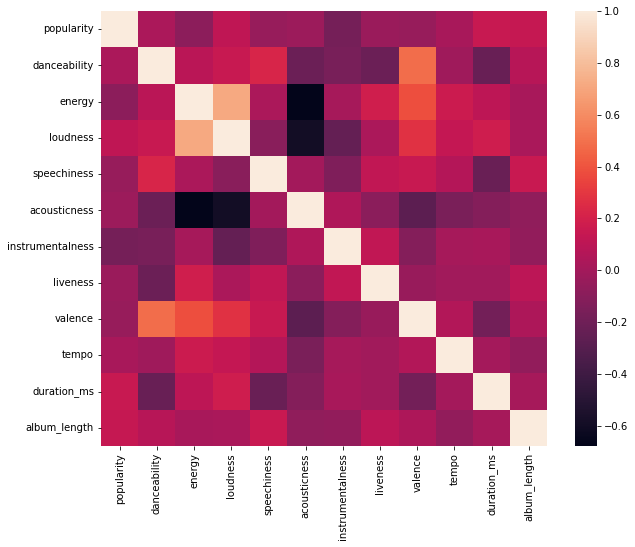

In [365]:
corr = data_out[numerical_features].corr()

fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, ax = ax)

plt.show()

In [378]:
highly_corr = []
for i in corr.index:
    for j in corr.columns:
        if 0.4 < abs(corr).loc[i, j] < 1 and (j, i) not in highly_corr:
            highly_corr.append((i, j))

#### Which features are strongly correlated?

We can see that there is some stronger levels of correlation between the above features. We have chosen all pairs that exhibit and correlation score of over 0.4 in absolute value. This is because we are concerned with strongly correlated cases and pairs such as (`loudness`, `valence`) show some levels of correlation, but not what we are currently interested in.


We shall display scattler plots for pair to give us a better understanding of their relationships.

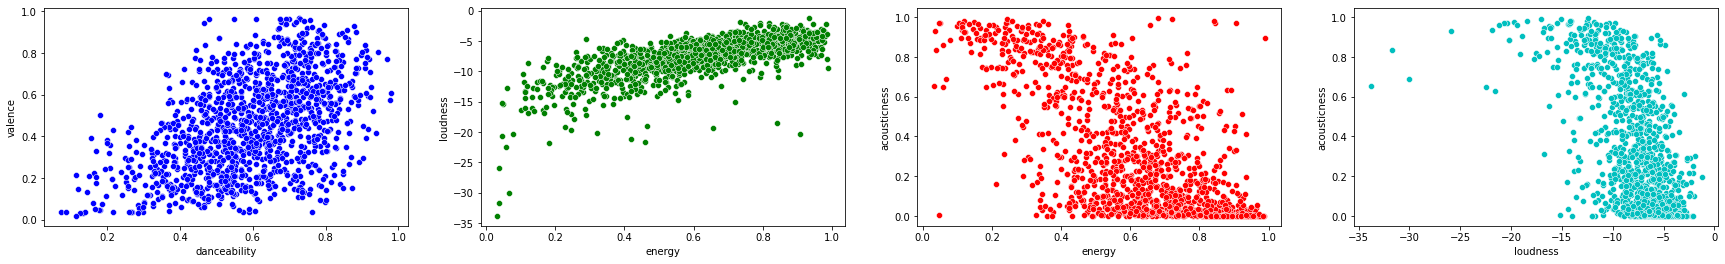

In [377]:
fig, ax = plt.subplots(
    nrows = (len(highly_corr) // 4),
    ncols = 4,
    figsize = (30, len(highly_corr))

)

for idx, pair in enumerate(highly_corr):
    sns.scatterplot(
        ax = ax[idx],
        data = data_out,
        x = pair[0],
        y = pair[1],
        color = colours[idx],
        ci = None
    )

plt.show()

#### What's interesting about the shape of these graphs?

Obviously the plots match the correlation values, but what is interesting about these scatter graphs are the gradients of the hypothetical line of best fits. The (`energy`, `loudness`) relationship is clearly the strongest; however, the gradient is very shallow. This tells us that a small change in the loudness rating of a song has dramatic effects to its energy ratings. This is something we would want to consider in modelling.

What's interseting is that the correlation between `energy` and `loudness` seems to be transitive i.e. since `energy` $\propto$
 `acousticness` and `acousticness` $\propto$ `loudness` then the fact that `energy` and `loudness` are also correlated suggests these three factors have a cyclical, transitive realationship.


#### Bool Vars

In [368]:
bool_df = data_out[bool_features]

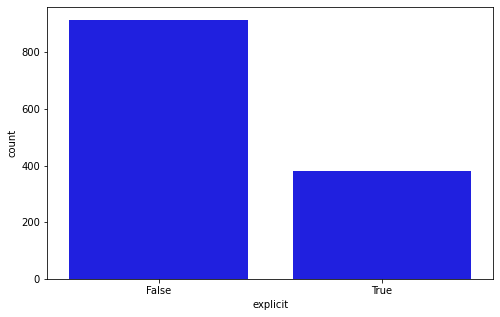

In [375]:
fig, ax = plt.subplots(
    nrows = 1,
    ncols = 1,
    figsize = (8, 5)

)

sns.countplot(
    data = bool_df,
    x = 'explicit',
    color = colours[0]
)

plt.show()

We can see that there is a slight difference between the value counts of the True and False values. There are roughly double the amount of False values compared to True, but this should not affect the results too much.

### Boolean Correlation with Numeric Feaetures

### Explicit Feature

In section we will be looking at the effect of the explicit feature on our numeric features. We will be looking to answer the following questions:

- How does the explicity of a song affect the audio features?
- Does any single audio feature jump out?
- Assuming this is the case, does this relationship make sense?

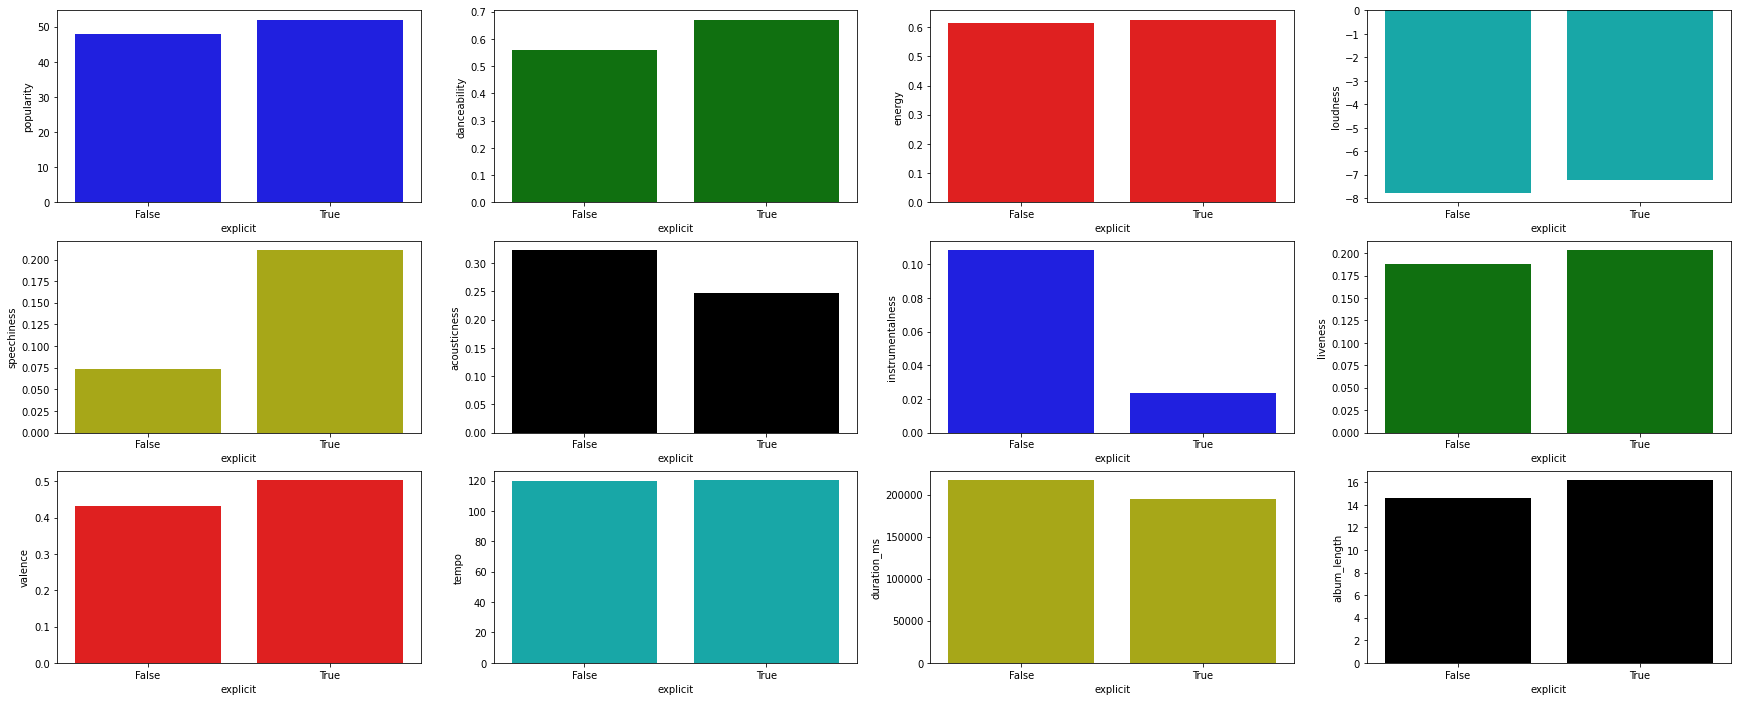

In [372]:
fig, ax = plt.subplots(
    nrows = numeric_df.shape[1] // 4,
    ncols = 4,
    figsize = (30, numeric_df.shape[1])
)

for idx, ncol in enumerate(numeric_df.columns):
    x, y = idx // 4, idx % 4
    sns.barplot(
        ax = ax[x, y],
        data = data_out,
        x = 'explicit',
        y = ncol,
        color = colours[idx],
        ci = None
    )

plt.show()

#### How does the explicity of a song affect the audio features?

- It does look like a track being `explicit` does affect some audio features.
- There is a slight difference in popularity based on whether a song is `explicit` or not. We can see that the `explicit` songs in our data have a higher average popularity score. Although the frequency of explicit tracks is half that of non-explicit track and that this difference is small, it is something to consider in further analysis. 
- Features to be more so affected are `speechiness`, `acousticness` and `instrumentalness` which has a massive gulf between the average score of this boolean. 
- We also see that the `danceability` of a track is affected by if it is `explicit` or not.

#### Does any single audio feature jump out? And do these relationships make sense?

- The two that jump out are `danceability` and, grouping the following features together, `speechiness`, `acousticness` and `instrumentalness`.
- The `acousticness` and `instrumentalness` relationships jump out because of the extreme differnce. However, these relationships are intutive because songs that have a high score for `acousticness` and `instrumentalness` conversely have a lack in lyrics because the emphasis is not there, and so the averages are so much higher for non-explicit tracks.
- The `speechiness` relationship also make sense for a similar reason as above, but in the opposite direction. This suggests that if a song has more words or a greater clarity of lyrics, it is more likely that an explicit word appears in the song.


## Step 5: Summarise and write a conclusion using markdown cells